In [1]:
!pip3 install tensorflow-estimator==2.6.0

In [3]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈 
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile 
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

In [4]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [5]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False): 
  
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [6]:
def draw_bounding_box_on_image(image, 
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [7]:
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1): 
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [10]:
from PIL import ImageOps, Image
from io import BytesIO
import requests

# 이미지 다운로드 및 크기 조정 함수
def download_and_resize_image(url, new_width, new_height, save_image):
    filename = url.split("/")[-1]
    
    # 이미지 다운로드
    response = requests.get(url)
    image_data = response.content
    image_data = BytesIO(image_data)  # 이미지 읽기
    pil_image = Image.open(image_data)
    
    # 이미지 크기 조정 (ANTIALIAS -> Resampling.LANCZOS)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.Resampling.LANCZOS)
    
    # 이미지 변환 및 저장
    pil_image_rgb = pil_image.convert("RGB")  # RGB로 변환
    if save_image:
        pil_image_rgb.save(filename, format="JPEG", quality=90)  # 이미지 저장
    
    return filename

# 테스트할 이미지 URL
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)  # new_width와 new_height를 변경해 보세요.


In [11]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  

detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [12]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [15]:
from PIL import Image, ImageDraw, ImageFont

# 바운딩 박스를 그리는 함수
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, display_str_list=()):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
              width=4, fill=color)

    # 텍스트의 높이 계산 방법 변경 (getsize -> getbbox)
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getbbox(display_str)[2:]  # getbbox는 텍스트의 바운딩 박스를 반환
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, top - text_height - 2 * margin),
                        (left + text_width, top)],
                       fill=color)
        draw.text((left + margin, top - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        top -= text_height + 2 * margin


Found 100 objects.
Inference time:  7.3637659549713135
Font not found, using default font.


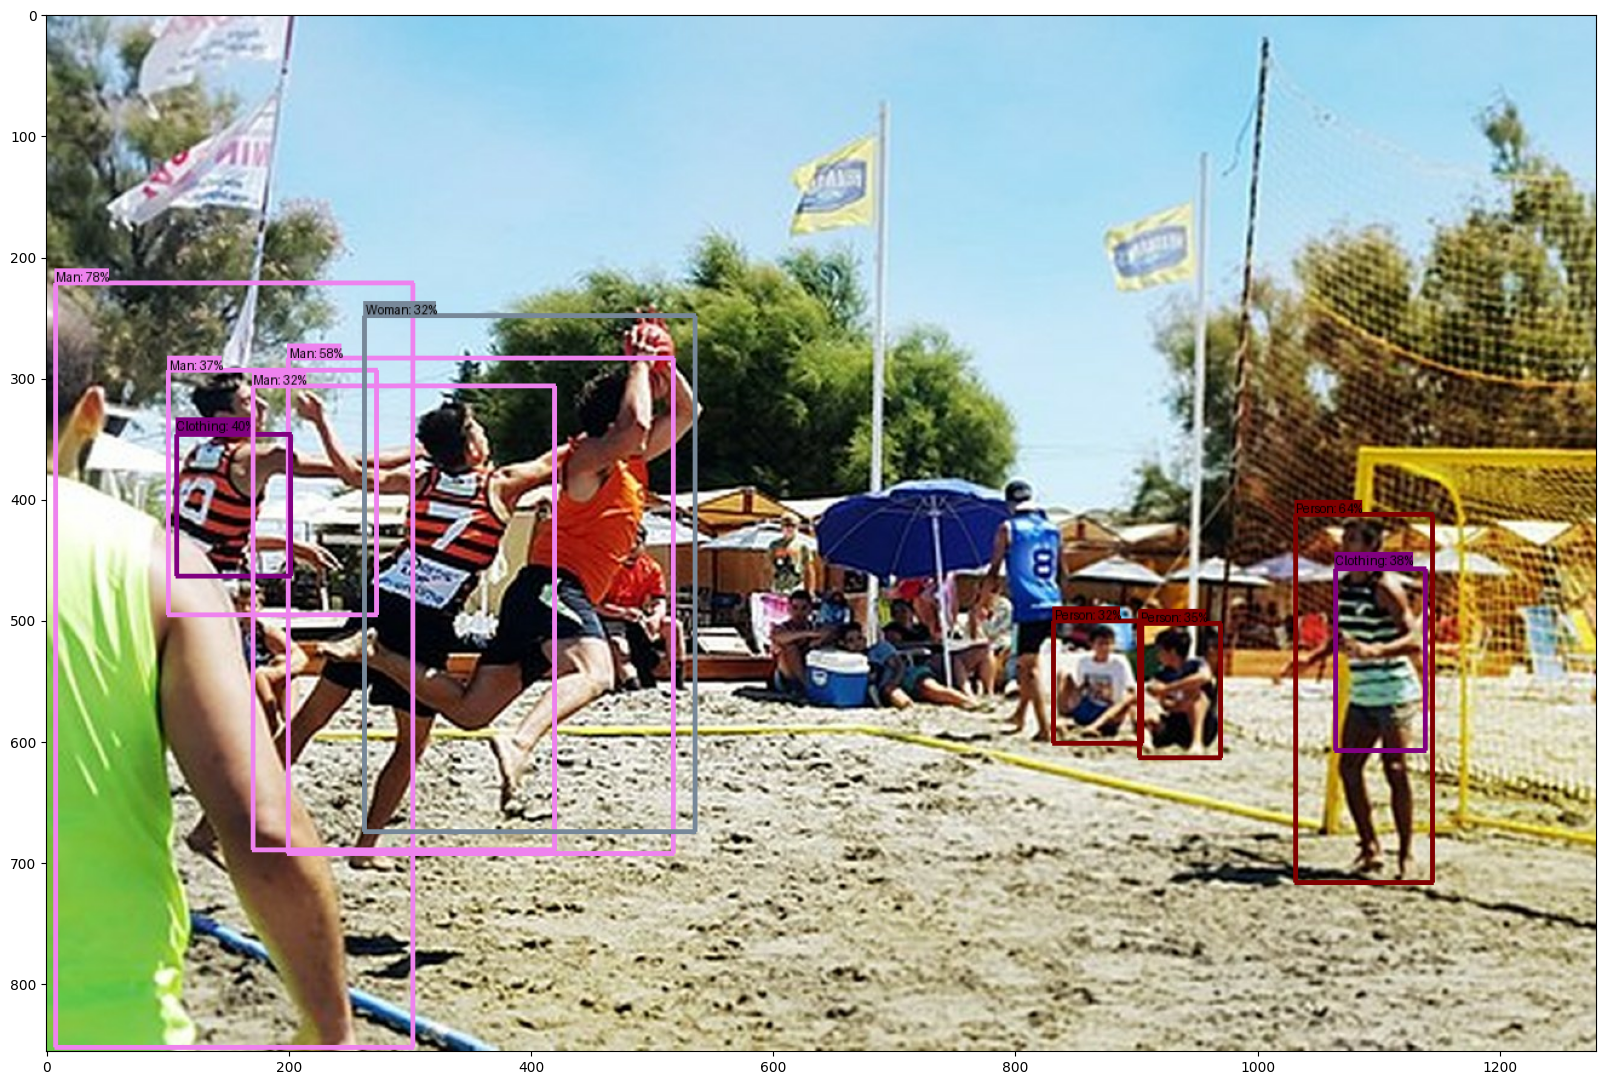

In [16]:
run_detector(detector, downloaded_image_path)

In [21]:
# 이미지 불러오기
image_url = "http://dn.joongdo.co.kr/mnt/images/file/2017y/01m/10d/20170110000019102_1.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)  # new_width와 new_height를 변경해 보세요.

Found 100 objects.
Inference time:  7.113086700439453
Font not found, using default font.


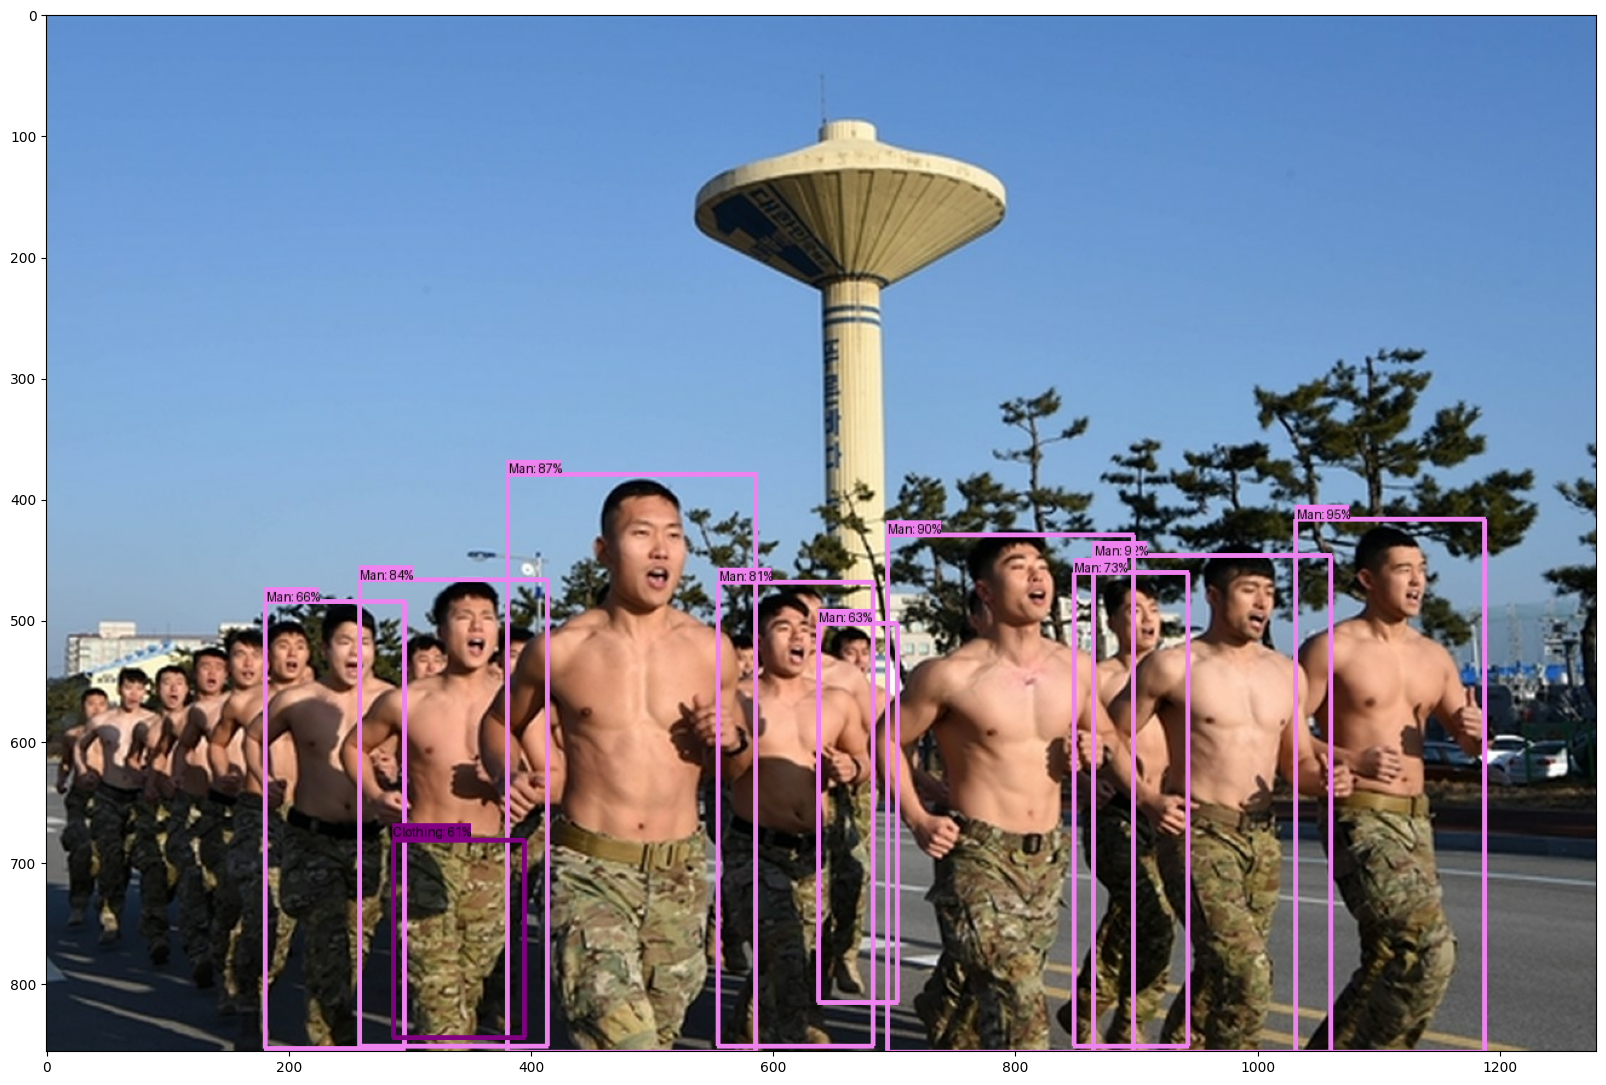

In [22]:
# 테스트
run_detector(detector, downloaded_image_path)


0: 416x640 14 persons, 1 car, 59.1ms
Speed: 2.7ms preprocess, 59.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


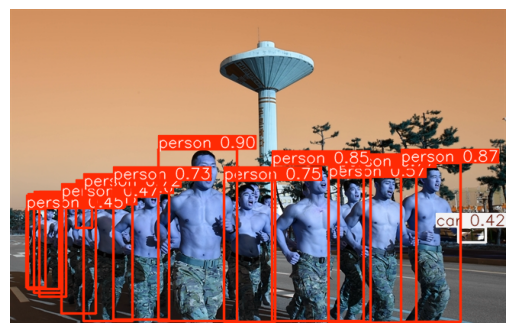

In [47]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from ultralytics import YOLO

# YOLO 모델 로드 (YOLOv8 Nano 모델 사용)
model = YOLO('yolov8n.pt')  # Pre-trained YOLOv8 Nano 모델을 사용

# 이미지 URL에서 다운로드
image_url = "http://dn.joongdo.co.kr/mnt/images/file/2017y/01m/10d/20170110000019102_1.jpg"
response = requests.get(image_url)

# 이미지 다운로드 성공 여부 확인
if response.status_code == 200:
    image_data = BytesIO(response.content)
    image = Image.open(image_data)

    # YOLO 모델로 객체 탐지 수행
    results = model(image)

    # YOLO 결과가 리스트인 경우 처리
    for result in results:
        # 탐지 결과가 적용된 이미지를 가져오기
        img_with_boxes = result.plot()  # plot()은 탐지 결과를 이미지에 그려줌
        
        # Matplotlib을 사용하여 이미지 시각화 (VSCode 출력에서 직접 표시)
        plt.imshow(img_with_boxes)
        plt.axis('off')  # 축을 표시하지 않음
        plt.show()  # VSCode에서 이미지 출력
else:
    print(f"이미지 다운로드 실패: 상태 코드 {response.status_code}")




In [48]:
print("1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 조금 느리지만 높은 정확성을 보였습니다.") 
print("2번째 모델인 YOLOV8은 굉장한 성능을 보인데다가 빠릅니다.")

1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 조금 느리지만 높은 정확성을 보였습니다.
2번째 모델인 YOLOV8은 굉장한 성능을 보인데다가 빠릅니다.
